In [1]:
PREDS_PATH = "../../predictions/temporalidad-test"
GS_PATH = "../../temporalidad/test/"
PREDS_PATH = PREDS_PATH.rstrip('/')
GS_PATH = GS_PATH.rstrip('/')

In [2]:
import os
import pandas as pd
import csv

In [3]:
preds_files = [filename for filename in os.listdir(PREDS_PATH) if filename.endswith(".ann")]

In [4]:
gs_files = [filename for filename in os.listdir(GS_PATH) if filename.endswith(".ann")]

In [5]:
preds_mentions = pd.DataFrame()
gs_mentions = pd.DataFrame()

In [9]:
for file in gs_files:
    file_df = pd.read_csv(os.path.join(GS_PATH, file), quoting=csv.QUOTE_NONE,
                 sep="\t", usecols=[0, 1, 2], names=['ann_id', "label", 'text'], header=None)
    # Filter out Attributes and AnnotatorNotes
    file_df = file_df[file_df['ann_id'].str.startswith('T')]
    # Rename and split columns
    file_df['start_span'] = file_df['label'].apply(lambda elem: int(elem.split()[1]))
    file_df['end_span'] = file_df['label'].apply(lambda elem: int(elem.split()[2]))
    file_df['label'] = file_df['label'].apply(lambda elem: elem.split()[0])
    file_df['filename'] = file
    gs_mentions = pd.concat([gs_mentions, file_df], ignore_index=True)
gs_mentions = gs_mentions[['filename', 'ann_id', 'label', 'start_span', 'end_span', 'text']]
gs_mentions['mention'] = gs_mentions.apply(lambda annot: annot['filename']+'|'+annot['label']+'|'+str(annot['start_span'])+'|'+str(annot['end_span']), axis=1)

In [11]:
for file in preds_files:
    file_df = pd.read_csv(os.path.join(PREDS_PATH, file), quoting=csv.QUOTE_NONE,
                 sep="\t", usecols=[0, 1, 2], names=['ann_id', "label", 'text'], header=None)
    # Filter out Attributes and AnnotatorNotes
    file_df = file_df[file_df['ann_id'].str.startswith('T')]
    # Rename and split columns
    file_df['start_span'] = file_df['label'].apply(lambda elem: int(elem.split()[1]))
    file_df['end_span'] = file_df['label'].apply(lambda elem: int(elem.split()[2]))
    file_df['label'] = file_df['label'].apply(lambda elem: elem.split()[0])
    file_df['filename'] = file
    preds_mentions = pd.concat([preds_mentions, file_df], ignore_index=True)
preds_mentions = preds_mentions[['filename', 'ann_id', 'label', 'start_span', 'end_span', 'text']]
preds_mentions['mention'] = preds_mentions.apply(lambda annot: annot['filename']+'|'+annot['label']+'|'+str(annot['start_span'])+'|'+str(annot['end_span']), axis=1)

In [205]:
# WRITE FILES TO MEDDOPLACE SCORING SCRIPT FORMAT (TSV)
#gs_mentions[['filename', 'ann_id', 'label', 'start_span', 'end_span', 'text']].to_csv(GS_PATH.split('/')[-1]+'.tsv', sep='\t', index=False, header=True)
#preds_mentions[['filename', 'ann_id', 'label', 'start_span', 'end_span', 'text']].to_csv(PREDS_PATH.split('/')[-1]+'.tsv', sep='\t', index=False, header=True)

In [12]:
gs_mentions["interval_closed"] = gs_mentions.apply(lambda annot: pd.Interval(annot['start_span'], annot['end_span'], closed='both'), axis=1)
gs_mentions["interval_open"] = gs_mentions.apply(lambda annot: pd.Interval(annot['start_span'], annot['end_span'], closed='neither'), axis=1)
preds_mentions["interval_closed"] = preds_mentions.apply(lambda annot: pd.Interval(annot['start_span'], annot['end_span'], closed='both'), axis=1)
preds_mentions["interval_open"] = preds_mentions.apply(lambda annot: pd.Interval(annot['start_span'], annot['end_span'], closed='neither'), axis=1)
gs_mentions['index'] = gs_mentions.index
preds_mentions['index'] = preds_mentions.index

In [13]:
df_merged = gs_mentions.merge(preds_mentions, on='filename', suffixes=['_gs', '_pred']) #, how='outer')

In [14]:
df_merged['exact_match'] = (df_merged['start_span_gs'] == df_merged['start_span_pred']) & (df_merged['end_span_gs'] == df_merged['end_span_pred'])
df_merged['exact_match'].value_counts()

exact_match
False    98405
True      3650
Name: count, dtype: int64

In [15]:
df_merged[df_merged['exact_match']].query("label_gs != label_pred")

,filename,ann_id_gs,label_gs,start_span_gs,end_span_gs,text_gs,mention_gs,interval_closed_gs,interval_open_gs,index_gs,ann_id_pred,label_pred,start_span_pred,end_span_pred,text_pred,mention_pred,interval_closed_pred,interval_open_pred,index_pred,exact_match
2201,S1134-928X2017000100006-1.ann,T11,SET,1333,1355,la mayor parte del día,S1134-928X2017000100006-1.ann|SET|1333|1355,"[1333, 1355]","(1333, 1355)",124,T5,DURATION,1333,1355,la mayor parte del día,S1134-928X2017000100006-1.ann|DURATION|1333|1355,"[1333, 1355]","(1333, 1355)",128,True
4087,caso_clinico_psiquiatria27.ann,T18,SET,1988,2004,el fin de semana,caso_clinico_psiquiatria27.ann|SET|1988|2004,"[1988, 2004]","(1988, 2004)",221,T18,DATE,1988,2004,el fin de semana,caso_clinico_psiquiatria27.ann|DATE|1988|2004,"[1988, 2004]","(1988, 2004)",235,True
5550,sample-009.intme.preil.ann,T10,SET,2069,2077,la noche,sample-009.intme.preil.ann|SET|2069|2077,"[2069, 2077]","(2069, 2077)",308,T19,TIME,2069,2077,la noche,sample-009.intme.preil.ann|TIME|2069|2077,"[2069, 2077]","(2069, 2077)",333,True
7287,S0034-98872018000600796-1.ann,T6,TIME,1283,1291,las 19 h,S0034-98872018000600796-1.ann|TIME|1283|1291,"[1283, 1291]","(1283, 1291)",393,T4,DURATION,1283,1291,las 19 h,S0034-98872018000600796-1.ann|DURATION|1283|1291,"[1283, 1291]","(1283, 1291)",410,True
9915,caso_clinico_oftalmologia261.ann,T8,DURATION,2463,2472,la semana,caso_clinico_oftalmologia261.ann|DURATION|2463...,"[2463, 2472]","(2463, 2472)",591,T2,SET,2463,2472,la semana,caso_clinico_oftalmologia261.ann|SET|2463|2472,"[2463, 2472]","(2463, 2472)",600,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100372,32637327B_ES.ann,T4,DURATION,457,471,las 13 semanas,32637327B_ES.ann|DURATION|457|471,"[457, 471]","(457, 471)",3849,T8,AGE,457,471,las 13 semanas,32637327B_ES.ann|AGE|457|471,"[457, 471]","(457, 471)",3957,True
100929,32637327B_ES.ann,T8,DATE,1869,1877,1 minuto,32637327B_ES.ann|DATE|1869|1877,"[1869, 1877]","(1869, 1877)",3868,T14,DURATION,1869,1877,1 minuto,32637327B_ES.ann|DURATION|1869|1877,"[1869, 1877]","(1869, 1877)",3963,True
100959,32637327B_ES.ann,T24,DATE,1880,1889,5 minutos,32637327B_ES.ann|DATE|1880|1889,"[1880, 1889]","(1880, 1889)",3869,T15,DURATION,1880,1889,5 minutos,32637327B_ES.ann|DURATION|1880|1889,"[1880, 1889]","(1880, 1889)",3964,True
101118,32637327B_ES.ann,T29,AGE,2809,2815,día 67,32637327B_ES.ann|AGE|2809|2815,"[2809, 2815]","(2809, 2815)",3874,T29,DATE,2809,2815,día 67,32637327B_ES.ann|DATE|2809|2815,"[2809, 2815]","(2809, 2815)",3978,True


In [16]:
# X is within Y (nested), and not exact match already
df_merged['pred_shorter'] = df_merged.apply(lambda annot: (annot['start_span_pred'] in annot['interval_closed_gs']) & (annot['end_span_pred'] in annot['interval_closed_gs']) & (not annot['exact_match']), axis=1)
df_merged['pred_longer'] = df_merged.apply(lambda annot: (annot['start_span_gs'] in annot['interval_closed_pred']) & (annot['end_span_gs'] in annot['interval_closed_pred']) & (not annot['exact_match']), axis=1).fillna(False)

In [32]:
# Some overlap
pred_shorter = df_merged[df_merged['pred_shorter']][['filename', 'label_gs', 'start_span_gs', 'end_span_gs', 'text_gs', 'label_pred', 'start_span_pred', 'end_span_pred', 'text_pred']]
pred_shorter.to_csv("fp_fn_analysis/pred_shorter.tsv", sep='\t', index=False, header=True)

In [33]:
# Some overlap
pred_longer = df_merged[df_merged['pred_longer']][['filename', 'label_gs', 'start_span_gs', 'end_span_gs', 'text_gs', 'label_pred', 'start_span_pred', 'end_span_pred', 'text_pred']]
pred_longer.to_csv("fp_fn_analysis/pred_longer.tsv", sep='\t', index=False, header=True)

In [19]:
# X starts within Y; AND X ends after Y (usually 0 cases)
df_merged['partial'] = df_merged.apply(lambda annot: 
                                       (annot['start_span_gs'] in annot['interval_open_pred']) & (annot['end_span_gs'] not in annot['interval_closed_pred'])
                                       |
                                       (annot['start_span_pred'] in annot['interval_open_gs']) & (annot['end_span_pred'] not in annot['interval_closed_gs']), axis=1)
df_merged[df_merged['partial']][['filename', 'label_gs', 'start_span_gs', 'end_span_gs', 'text_gs', 'label_pred', 'start_span_pred', 'end_span_pred', 'text_pred']].to_csv("fp_fn_analysis/partial.tsv", sep='\t', index=False, header=True)

In [20]:
df_merged[(df_merged['pred_shorter'] | df_merged['pred_longer'] | df_merged['partial'])].query("label_gs != label_pred")

,filename,ann_id_gs,label_gs,start_span_gs,end_span_gs,text_gs,mention_gs,interval_closed_gs,interval_open_gs,index_gs,...,end_span_pred,text_pred,mention_pred,interval_closed_pred,interval_open_pred,index_pred,exact_match,pred_shorter,pred_longer,partial
1598,S1134-80462017000300145-1.ann,T17,DATE,2041,2050,al 6º mes,S1134-80462017000300145-1.ann|DATE|2041|2050,"[2041, 2050]","(2041, 2050)",63,...,2045,al 6,S1134-80462017000300145-1.ann|DURATION|2041|2045,"[2041, 2045]","(2041, 2045)",66,False,True,False,False
1600,S1134-80462017000300145-1.ann,T17,DATE,2041,2050,al 6º mes,S1134-80462017000300145-1.ann|DATE|2041|2050,"[2041, 2050]","(2041, 2050)",63,...,2050,mes,S1134-80462017000300145-1.ann|DURATION|2047|2050,"[2047, 2050]","(2047, 2050)",68,False,True,False,False
4719,caso_clinico_urologia318.ann,T9,AGE,133,147,la 38.a semana,caso_clinico_urologia318.ann|AGE|133|147,"[133, 147]","(133, 147)",246,...,139,la 38.,caso_clinico_urologia318.ann|DATE|133|139,"[133, 139]","(133, 139)",251,False,True,False,False
5346,cc_geneticas81.ann,T5,DATE,347,361,las 31 semanas,cc_geneticas81.ann|DATE|347|361,"[347, 361]","(347, 361)",299,...,350,las,cc_geneticas81.ann|AGE|347|350,"[347, 350]","(347, 350)",313,False,True,False,False
5347,cc_geneticas81.ann,T5,DATE,347,361,las 31 semanas,cc_geneticas81.ann|DATE|347|361,"[347, 361]","(347, 361)",299,...,361,31 semanas,cc_geneticas81.ann|DURATION|351|361,"[351, 361]","(351, 361)",314,False,True,False,False
5883,S1135-76062014000200007-1.ann,T6,DURATION,754,771,las últimas horas,S1135-76062014000200007-1.ann|DURATION|754|771,"[754, 771]","(754, 771)",327,...,783,las últimas horas de la tarde,S1135-76062014000200007-1.ann|TIME|754|783,"[754, 783]","(754, 783)",342,False,False,True,False
5888,S1135-76062014000200007-1.ann,T7,SET,775,783,la tarde,S1135-76062014000200007-1.ann|SET|775|783,"[775, 783]","(775, 783)",328,...,783,las últimas horas de la tarde,S1135-76062014000200007-1.ann|TIME|754|783,"[754, 783]","(754, 783)",342,False,False,True,False
8595,cc_onco1306.ann,T9,SET,2405,2415,/2 semanas,cc_onco1306.ann|SET|2405|2415,"[2405, 2415]","(2405, 2415)",499,...,2415,2 semanas,cc_onco1306.ann|DURATION|2406|2415,"[2406, 2415]","(2406, 2415)",509,False,True,False,False
11055,sample-008.sugen.chico.ann,T23,TIME,3295,3335,"ayer , hacia las 00 : 03 aproximadamente",sample-008.sugen.chico.ann|TIME|3295|3335,"[3295, 3335]","(3295, 3335)",612,...,3299,ayer,sample-008.sugen.chico.ann|DATE|3295|3299,"[3295, 3299]","(3295, 3299)",640,False,True,False,False
17266,S1130-01082010000300011-1.ann,T5,DURATION,1667,1677,/4 semanas,S1130-01082010000300011-1.ann|DURATION|1667|1677,"[1667, 1677]","(1667, 1677)",910,...,1668,/,S1130-01082010000300011-1.ann|SET|1667|1668,"[1667, 1668]","(1667, 1668)",945,False,True,False,False


In [21]:
# Most frequent FP
not_spurious = df_merged[(df_merged['exact_match'])] # | df_merged['pred_shorter'] | df_merged['pred_longer'] | df_merged['partial'])]['mention_pred'].unique()
spurious_mentions = preds_mentions[~preds_mentions['mention'].isin(gs_mentions['mention']) ]

In [22]:
cm_exact = df_merged[(df_merged['exact_match'])][['label_gs', 'label_pred']].value_counts().reset_index().pivot_table(index='label_gs', columns='label_pred', values='count', fill_value=0)
cm_exact

label_pred,AGE,DATE,DURATION,SET,TIME
label_gs,,,,,
AGE,443,2,4,0,0
DATE,3,1233,7,2,1
DURATION,4,4,1069,3,1
SET,0,3,2,745,11
TIME,0,0,6,9,98


In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
all_labels = gs_mentions['label'].sort_values().unique()

In [36]:
exact_mentions_gs = df_merged[df_merged['exact_match']]['mention_gs']
exact_mentions_pred = df_merged[df_merged['exact_match']]['mention_pred']

In [30]:
cm_exact_df = pd.DataFrame(cm_exact, index=all_labels, columns=all_labels)
cm_exact_df['Missing'] = gs_mentions[~gs_mentions['mention'].isin(exact_mentions_gs)]['label'].value_counts().sort_index()
cm_exact_df.loc['Spurious'] = preds_mentions[~preds_mentions['mention'].isin(exact_mentions_pred)]['label'].value_counts().sort_index()
cm_exact_df = cm_exact_df.fillna(0)

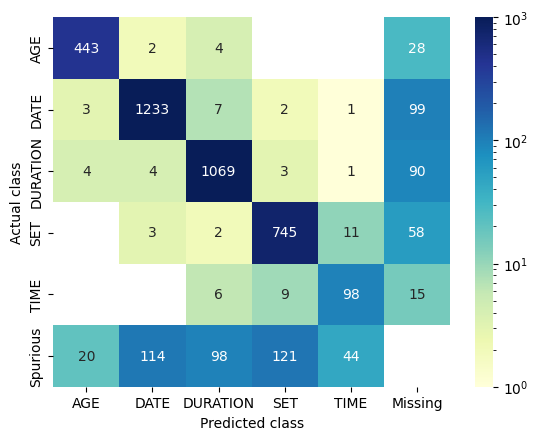

In [31]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize, AsinhNorm, NoNorm, BoundaryNorm, FuncNorm, CenteredNorm, PowerNorm
import matplotlib.pyplot as plt

sns.heatmap(cm_exact_df.astype(int), annot=True, fmt='d', norm=LogNorm(vmax=1000), cmap='YlGnBu', )
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.savefig("strict_entity_confusion_matrix_norm.png", bbox_inches='tight')
plt.show()

In [37]:
pred_shorter[['label_gs', 'label_pred']].value_counts().reset_index().pivot_table(index='label_gs', columns='label_pred', values='count', fill_value=0)

label_pred,AGE,DATE,DURATION,SET,TIME
label_gs,,,,,
AGE,7,3,4,0,0
DATE,1,32,4,3,2
DURATION,2,3,37,4,0
SET,0,0,4,22,5
TIME,0,1,2,0,10


In [27]:
spurious_mentions[['filename', 'label', 'start_span', 'end_span', 'text']].to_csv("fp_fn_analysis/spurious_mentions.tsv", sep='\t', index=False, header=True)

In [28]:
df_merged[(df_merged['exact_match'])]['mention_gs'].nunique()

2341

In [280]:
df_merged[df_merged['mention_gs'] == "cc_reumatologia244.ann|GPE_GEN|68|79"]

,filename,ann_id_gs,label_gs,start_span_gs,end_span_gs,text_gs,mention_gs,interval_closed_gs,interval_open_gs,index_gs,...,end_span_pred,text_pred,mention_pred,interval_closed_pred,interval_open_pred,index_pred,exact_match,pred_shorter,pred_longer,partial
1472,cc_reumatologia244.ann,T1,GPE_GEN,68,79,casco rural,cc_reumatologia244.ann|GPE_GEN|68|79,"[68, 79]","(68, 79)",84,...,79,casco rural,cc_reumatologia244.ann|GEO_GEN|68|79,"[68, 79]","(68, 79)",85,True,False,False,False
1473,cc_reumatologia244.ann,T1,GPE_GEN,68,79,casco rural,cc_reumatologia244.ann|GPE_GEN|68|79,"[68, 79]","(68, 79)",84,...,101,municipio de Tela,cc_reumatologia244.ann|GPE_NOM|84|101,"[84, 101]","(84, 101)",86,False,False,False,False


In [30]:
# Most frequent FN
not_missing = df_merged[(df_merged['exact_match'])]['mention_gs'].unique() # | df_merged['pred_shorter'] | df_merged['pred_longer'] | df_merged['partial'])]['mention_gs'].unique()
missing_mentions = gs_mentions[(~gs_mentions['mention'].isin(preds_mentions['mention']) & gs_mentions['mention'].isin(not_missing))]
missing_mentions

,filename,ann_id,label,start_span,end_span,text,mention,interval_closed,interval_open,index
32,S0716-10182008000600010-1.ann,T4,FAC_GEN,725,749,Cátedra de Parasitología,S0716-10182008000600010-1.ann|FAC_GEN|725|749,"[725, 749]","(725, 749)",32
84,cc_reumatologia244.ann,T1,GPE_GEN,68,79,casco rural,cc_reumatologia244.ann|GPE_GEN|68|79,"[68, 79]","(68, 79)",84
256,caso_clinico_psiquiatria303.ann,T4,GEO_GEN,5000,5008,estanque,caso_clinico_psiquiatria303.ann|GEO_GEN|5000|5008,"[5000, 5008]","(5000, 5008)",256
258,caso_clinico_psiquiatria303.ann,T6,COMUNIDAD,3372,3382,extranjero,caso_clinico_psiquiatria303.ann|COMUNIDAD|3372...,"[3372, 3382]","(3372, 3382)",258
273,S1135-76062010000200003-1.ann,T1,FAC_GEN,99,112,campo de golf,S1135-76062010000200003-1.ann|FAC_GEN|99|112,"[99, 112]","(99, 112)",273
274,S1135-76062010000200003-1.ann,T2,FAC_GEN,220,233,campo de golf,S1135-76062010000200003-1.ann|FAC_GEN|220|233,"[220, 233]","(220, 233)",274
290,cc_geneticas275.ann,T11,DEPARTAMENTO,2371,2380,USF Rural,cc_geneticas275.ann|DEPARTAMENTO|2371|2380,"[2371, 2380]","(2371, 2380)",290
442,caso_clinico_urologia178.ann,T18,COMUNIDAD,391,401,extranjero,caso_clinico_urologia178.ann|COMUNIDAD|391|401,"[391, 401]","(391, 401)",442
448,S1135-76062009000400006-1.ann,T1,GPE_NOM,96,112,Isla Bastimentos,S1135-76062009000400006-1.ann|GPE_NOM|96|112,"[96, 112]","(96, 112)",448
557,caso_clinico_psiquiatria391.ann,T24,FAC_NOM,1676,1693,taller Baix campi,caso_clinico_psiquiatria391.ann|FAC_NOM|1676|1693,"[1676, 1693]","(1676, 1693)",557


In [31]:
df_merged[(df_merged['exact_match'])]['mention_gs'].nunique()

2341

In [32]:
not_missing

array(['caso_clinico_psiquiatria449.ann|COMUNIDAD|5343|5353',
       'caso_clinico_psiquiatria449.ann|DEPARTAMENTO|1030|1047',
       'caso_clinico_psiquiatria449.ann|FAC_GEN|6878|6883', ...,
       'S0716-10182013000300009-1.ann|GPE_NOM|135|151',
       'S0716-10182013000300009-1.ann|GEO_GEN|67|79',
       'S0716-10182013000300009-1.ann|GPE_NOM|601|606'], dtype=object)

In [33]:
gs_mentions['mention'].isin(preds_mentions['mention'])

0       True
1       True
2       True
3       True
4       True
        ... 
2673    True
2674    True
2675    True
2676    True
2677    True
Name: mention, Length: 2678, dtype: bool

In [34]:
missing_mentions[['filename', 'label', 'start_span', 'end_span', 'text']].to_csv("fp_fn_analysis/missing_mentions.tsv", sep='\t', index=False, header=True)

In [35]:
df_merged[df_merged['pred_shorter']]['text_pred'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/pred_shorter_pred_top.tsv", sep='\t', index=True, header=True)
df_merged[df_merged['pred_shorter']]['text_gs'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/pred_shorter_gs_top.tsv", sep='\t', index=True, header=True)
df_merged[df_merged['pred_longer']]['text_pred'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/pred_longer_pred_top.tsv", sep='\t', index=True, header=True)
df_merged[df_merged['pred_longer']]['text_gs'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/pred_longer_gs_top.tsv", sep='\t', index=True, header=True)
missing_mentions['text'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/missing_mentions_top.tsv", sep='\t', index=True, header=True)
spurious_mentions['text'].apply(lambda text: text.lower()).value_counts().to_csv("fp_fn_analysis/spurious_mentions_top.tsv", sep='\t', index=True, header=True)

In [36]:
# Get TP, FP, FN
df_remaining = df_merged.copy()
TPs_gs = df_remaining[df_remaining['exact_match']]['index_gs'].unique()
TPs_pred = df_remaining[df_remaining['exact_match']]['index_pred'].unique()

In [37]:
df_remaining = df_remaining[~(df_remaining['index_gs'].isin(TPs_gs) | df_remaining['index_pred'].isin(TPs_pred))]

In [38]:
ov_TPs_gs = df_remaining[df_remaining['exact_match'] | df_remaining['pred_shorter'] | df_remaining['pred_longer'] | df_remaining['partial']]['index_gs'].unique()
ov_TPs_pred = df_remaining[df_remaining['exact_match'] | df_remaining['pred_shorter'] | df_remaining['pred_longer'] | df_remaining['partial']]['index_pred'].unique()

In [39]:
df_remaining = df_remaining[~(df_remaining['index_gs'].isin(TPs_gs) | df_remaining['index_pred'].isin(TPs_pred))]

In [40]:
gs_vs_pred = df_merged[(df_merged['exact_match'] | df_merged['pred_shorter'] | df_merged['pred_longer'] | df_merged['partial'])][['label_gs', 'label_pred']] #.query("label_gs != label_pred")
gs_vs_pred

,label_gs,label_pred
14,COMUNIDAD,COMUNIDAD
30,DEPARTAMENTO,DEPARTAMENTO
76,FAC_GEN,FAC_GEN
110,FAC_GEN,FAC_GEN
142,FAC_GEN,FAC_GEN
...,...,...
54337,GPE_NOM,GPE_NOM
54342,GPE_NOM,GPE_NOM
54350,GPE_NOM,GPE_NOM
54353,GEO_GEN,GEO_GEN


In [50]:
gs_vs_pred_cm = confusion_matrix(gs_vs_pred['label_gs'], gs_vs_pred['label_pred'], labels=all_labels)

In [53]:
gs_vs_pred_cm_df = pd.DataFrame(gs_vs_pred_cm, index=all_labels, columns=all_labels)
gs_vs_pred_cm_df['Spurious'] = spurious_mentions['label'].value_counts().reindex(all_labels, fill_value=0)
gs_vs_pred_cm_df.loc['Missing'] = missing_mentions['label'].value_counts().reindex(all_labels, fill_value=0)
gs_vs_pred_cm_df = gs_vs_pred_cm_df.fillna(0)